This is based off of this Project:

1) provides the forward model of the imaging process.  Namely given a numerical phantom (“image”) of say the head), takes user provided field maps for the B0 magnet, and the gradients and RF coil and generates what the kspace of that object is expected to be.
2) Show the conventional FFT reconstruction of this modeled data and compare it to the ground truth object with some set of metrics (of distortion etc.)
3) Do an iterative reconstruction of the ground-truth object using the forward model to give a "best case” look at how this configuration of fields would image.  Note that if the fields render an ill-posed inverse problem, there will be residual aliasing and noise amplification.  Provide metrics of these.

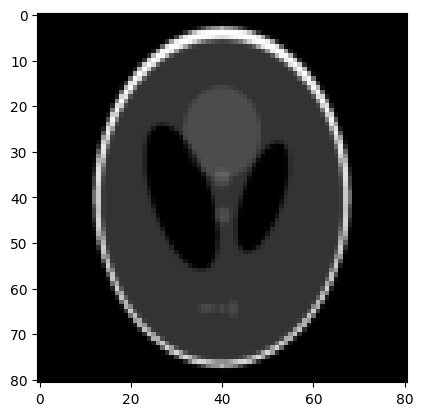

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fftshift, fft2, ifft2
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import pandas as pd

# Re-generate and resize Shepp-Logan phantom
phantom = shepp_logan_phantom()
phantom = resize(phantom, (81, 81))
phantom /= np.max(phantom)
phantom = phantom * (1 + 1j)  # Make the phantom complex


N_spins = 81  # Number of spins in the phantom
# # Phantom is a 2D delta function (single point in the center)
# phantom = np.zeros((N_spins, N_spins), dtype=np.complex128)  
# phantom[N_spins//2, N_spins//2] = 1

# # Load the B0 field map from the csv file
# B0_field_map = pd.read_csv('2Dslice.csv', header=None).values

# # Plot the B0 field map
# plt.imshow(np.abs(B0_field_map), cmap='gray')
# plt.show()

# Plot the phantom
plt.imshow(np.abs(phantom), cmap='gray')
plt.show()



 


gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
g_mult = 6 # Gradient multiplication factor
Gx = 0.004755753 * g_mult  # Gradient strength in T/m
Gy = 0.004755753 * g_mult # Gradient strength in T/m
B0 = 1.0  # B0 field in T

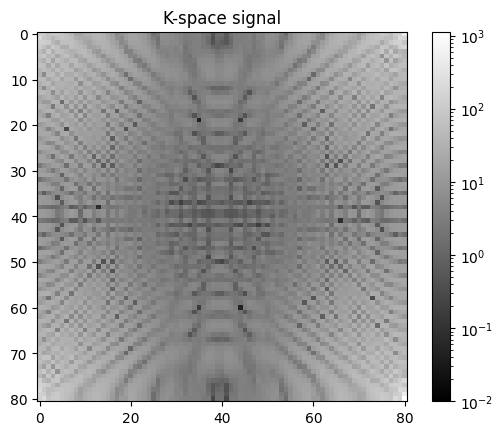

In [23]:
# RF pulse (90 degree flip)
angle = np.pi / 2
phantom *= np.exp(1j * angle)

# Time intervals for the gradients
tau = 2e-3
time = np.linspace(-tau/2,tau/2,N_spins)

# Gradient fields (assuming same for x and y directions)
Gx_values = time * Gx
Gy_values = time * Gx

# k-space trajectory (assuming same for x and y directions)
kx_values = gamma * Gx_values
ky_values = gamma * Gy_values

# Define field of view
FOV = .2  # meters
x_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
y_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
x_values, y_values = np.meshgrid(x_values, y_values)  # Create 2D coordinate grid


# Compute k-space values
k_space = np.zeros((N_spins, N_spins), dtype=np.complex128)
for i, kx in enumerate(kx_values):
    for j, ky in enumerate(ky_values):
        k_space[i, j] = np.sum(phantom * np.exp(-1j * (kx * x_values + ky * y_values)))

# Apply FFT shift
k_space_shifted = fftshift(k_space)

# Plot the absolute k-space signal
plt.figure()
plt.imshow(np.abs(k_space_shifted), cmap='gray', norm=LogNorm(vmin=0.01))
plt.title('K-space signal')
plt.colorbar()
plt.show()

# # Perform inverse FFT to reconstruct the image
# reconstructed_image = ifft2(ifftshift(k_space_shifted))

# # Display the reconstructed image
# plt.figure()
# plt.imshow(np.abs(reconstructed_image), cmap='gray')
# plt.title('Reconstructed Image')
# plt.colorbar()
# plt.show()


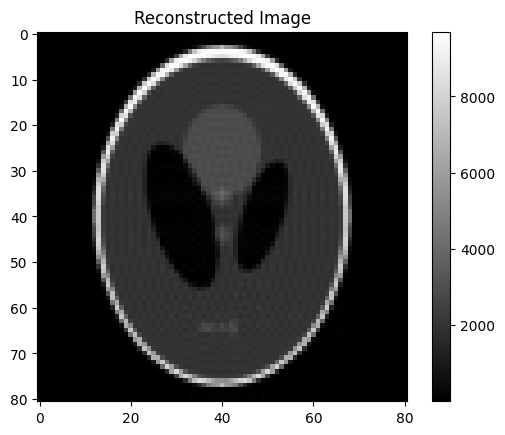

In [24]:
x_values_1 = np.linspace(-FOV / 2, FOV / 2, N_spins)
y_values_1 = np.linspace(-FOV / 2, FOV / 2, N_spins)


def inverse_fourier_2d(k_space):
    # Allocate a space for the output image
    image = np.zeros((N_spins, N_spins), dtype=np.complex128)
    
    # Iterate through each pixel in k-space
    for m in range(N_spins):
        for n in range(N_spins):
            # For each pixel, calculate the inverse Fourier transform
            for i in range(N_spins):
                for j in range(N_spins):
                    image[m, n] += k_space[i, j] * np.exp(1j * (kx_values[i] * x_values_1[m] + ky_values[j] * y_values_1[n]))
    

    
    return image

# Apply the inverse Fourier transform to the k-space data
reconstructed_image = inverse_fourier_2d(k_space)

# Plot the absolute value of the reconstructed image
plt.figure()
plt.imshow(np.abs(reconstructed_image.T), cmap='gray')
plt.colorbar()
plt.title('Reconstructed Image')
plt.show()
